In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("/jet/prs/workspace/rxrx1-utils")
from rxrx import io as rio

import settings_model

In [2]:
import preprocess_data
data = preprocess_data.rxrx_all()

Loading metadata...
Metadata shape: (125510, 10)
81224 values in ids_train
81224 values in labels_train
24 values in ids_train_debug
24 values in labels_train_debug
4492 values in ids_valid
4492 values in labels_valid
24 values in ids_valid_debug
24 values in labels_valid_debug
39794 values in ids_test
39794 values in labels_test
Total ids: 125558.0
Calculating normalization factors by experiment...


In [3]:
import dataset_generator
datasets, loaders = dataset_generator.create_datasets_and_loaders(data, settings_model.batch_size, 
                                                                  settings_model.basepath_data, 
                                                                  settings_model.original_image_size)

Image batch size: torch.Size([16, 6, 128, 128]). Label batch size: 16.
Average pixel value in batch: 0.41680
Stddev pixel value in batch: 1.11352


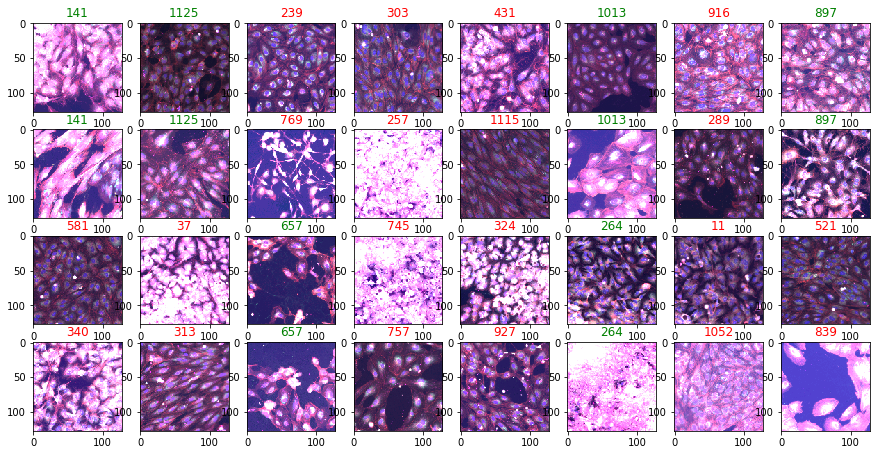

In [4]:
dataset_generator.show_batch(loaders["train"])    
# dataset_generator.show_batch(loaders["test"])

In [5]:
import torch
import torch.nn as nn
# from .utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class SiameseResNet(nn.Module):

    def __init__(self, block, layers, input_channels=6, embedding_size=128, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(SiameseResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, embedding_size)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        
        return out1, out2
    
def _siamese_resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = SiameseResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def siamese_resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>'_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _siamese_resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>'_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>'_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>'_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>'_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


In [47]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
class WChi2Loss(torch.nn.Module):
    """
    Weighted Chi Squared Loss.
    Based on: https://zpascal.net/cvpr2014/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf
    """

    def __init__(self, margin=2.0):
        super(WChi2Loss, self).__init__()
#         self.margin = margin

    def forward(self, output1, output2, label):
#         euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return None

In [7]:
class SimpleEucliDistLoss(torch.nn.Module):
    """
    Simple Euclidean Distance Loss.
    """

    def __init__(self, margin=2.0):
        super(SimpleEucliDistLoss, self).__init__()
#         self.margin = margin

    def forward(self, output1, output2, label):
        sig = nn.Sigmoid()
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss = torch.mean(torch.pow(euclidean_distance, 2))
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return sig(loss)

In [12]:
from matplotlib import pyplot as plt

def show_plot(loss):
    plt.plot(range(len(loss)),loss)
    plt.show()

Epoch [0]	Iter [0/100]	Current loss: 0.9998326301574707
Epoch [0]	Iter [1/100]	Current loss: 0.9995874762535095
Epoch [0]	Iter [2/100]	Current loss: 0.9972898960113525
Epoch [0]	Iter [3/100]	Current loss: 0.9968540072441101
Epoch [0]	Iter [4/100]	Current loss: 0.9781590700149536
Epoch [0]	Iter [5/100]	Current loss: 0.9216628074645996
Epoch [0]	Iter [6/100]	Current loss: 0.8959370851516724
Epoch [0]	Iter [7/100]	Current loss: 0.8480278253555298
Epoch [0]	Iter [8/100]	Current loss: 0.8169703483581543
Epoch [0]	Iter [9/100]	Current loss: 0.7824935913085938
Epoch [0]	Iter [10/100]	Current loss: 0.7340792417526245
Epoch [0]	Iter [11/100]	Current loss: 0.683066189289093
Epoch [0]	Iter [12/100]	Current loss: 0.6495562195777893
Epoch [0]	Iter [13/100]	Current loss: 0.6176820397377014
Epoch [0]	Iter [14/100]	Current loss: 0.5914334654808044
Epoch [0]	Iter [15/100]	Current loss: 0.5724942684173584
Epoch [0]	Iter [16/100]	Current loss: 0.5563398003578186
Epoch [0]	Iter [17/100]	Current loss: 0.54

Epoch [1]	Iter [46/100]	Current loss: 0.500646710395813
Epoch [1]	Iter [47/100]	Current loss: 0.5005892515182495
Epoch [1]	Iter [48/100]	Current loss: 0.5005588531494141
Epoch [1]	Iter [49/100]	Current loss: 0.5005849599838257
Epoch [1]	Iter [50/100]	Current loss: 0.5006818175315857
Epoch [1]	Iter [51/100]	Current loss: 0.5005925297737122
Epoch [1]	Iter [52/100]	Current loss: 0.5005561113357544
Epoch [1]	Iter [53/100]	Current loss: 0.5005530118942261
Epoch [1]	Iter [54/100]	Current loss: 0.5005963444709778
Epoch [1]	Iter [55/100]	Current loss: 0.5006051063537598
Epoch [1]	Iter [56/100]	Current loss: 0.5006120800971985
Epoch [1]	Iter [57/100]	Current loss: 0.5005643367767334
Epoch [1]	Iter [58/100]	Current loss: 0.5005999803543091
Epoch [1]	Iter [59/100]	Current loss: 0.5006143450737
Epoch [1]	Iter [60/100]	Current loss: 0.5005916357040405
Epoch [1]	Iter [61/100]	Current loss: 0.5005252957344055
Epoch [1]	Iter [62/100]	Current loss: 0.5005444288253784
Epoch [1]	Iter [63/100]	Current los

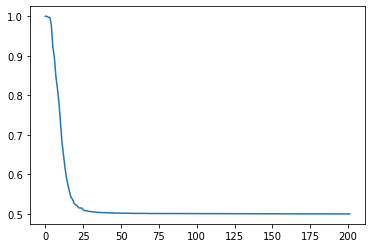

In [15]:
from torch import optim
import torch.nn.functional as F

torch.manual_seed(42)

model = siamese_resnet18().cuda()
criterion = SimpleEucliDistLoss()
optimizer = optim.Adam(model.parameters(), lr = 1.e-3 )

loss_history = []
num_steps = 100
# set model to training mode
model.train()
    
for epoch in range(2):
    for i, data in enumerate(loaders["train"]):
        if i>num_steps:
            break
        img_batch1, img_batch2, is_same_batch, label_batch1, label_batch2 = data
        img_batch1, img_batch2 = img_batch1.type(torch.float32).cuda(), img_batch2.type(torch.float32).cuda()
        is_same_batch = is_same_batch.type(torch.float32).cuda()
        optimizer.zero_grad()
        output_batch1, output_batch2 = model(img_batch1, img_batch2)
        loss = criterion(output_batch1, output_batch2, is_same_batch)
        loss.backward()
        optimizer.step()
        if i%1 == 0:
            print("Epoch [{}]\tIter [{}/{}]\tCurrent loss: {}".format(epoch, i, num_steps, loss.item()))
            loss_history.append(loss.item())
show_plot(loss_history)